In [1]:
import os
import re

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.figsize'] = (16, 9)

In [4]:
ROOT_DIR = "RawData"

In [5]:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("notebook", font_scale = 1.5)

# 1. Upload Datasets

In [6]:
def get_data(filename, dir = ROOT_DIR, force_download = False):
    if force_download or not os.path.exists(filename):
        data = pd.ExcelFile(os.path.join(dir, filename))
    return data

In [7]:
BE_data = get_data('BE_RawData_VPython.xlsx')
FR_data = get_data('FR_RawData_VPython.xlsx')
EU_data = get_data('EU_RawData_VPython.xlsx')

In [8]:
print("BE_data, sheet names = \n", BE_data.sheet_names, "\n\n", 
      "FR_data, sheet names = \n", FR_data.sheet_names, "\n\n", 
      "EU_data, sheet names = \n", EU_data.sheet_names, "\n")

BE_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'FlatGlassInd_GlassInd', 'RawMat_GlassInd_ABS'] 

 FR_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'RawMat_PlateGlass', 'RawMat_WindowGlass', 'RawMat_FloatGlass', 'RawMat_FlatGlass_ABS', 'emissions'] 

 EU_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'EnergyUse', 'pollution', 'production costs'] 



# 2. Postprocessing of the French and Belgian datasets

## a. Production of flat glass

In [9]:
#Creating a DataFrame only with production data
FR_Prod = FR_data.parse('prod').set_index('year')
BE_Prod = BE_data.parse('prod').set_index('year')

#Creating a new DataFrame for Belgian and French flat glass production
BE_FR_FlatGlassProd = FR_Prod[['flat glass, kt']].copy()
BE_FR_FlatGlassProd.rename(columns={'flat glass, kt':'FR [kt]'},
                           inplace=True)

BE_FR_FlatGlassProd['BE [kt]'] = BE_Prod['flat glass, kt']

BE_FR_FlatGlassProd

,FR [kt],BE [kt]
year,,
1945,108.3,NaN
1946,173.8,NaN
1947,198.3,NaN
1948,220.2,NaN
1949,191.3,NaN
...,...,...
2016,NaN,NaN
2017,NaN,NaN
2018,NaN,NaN


Text(0.5, 0.98, 'Flat glass production [kt/y]')

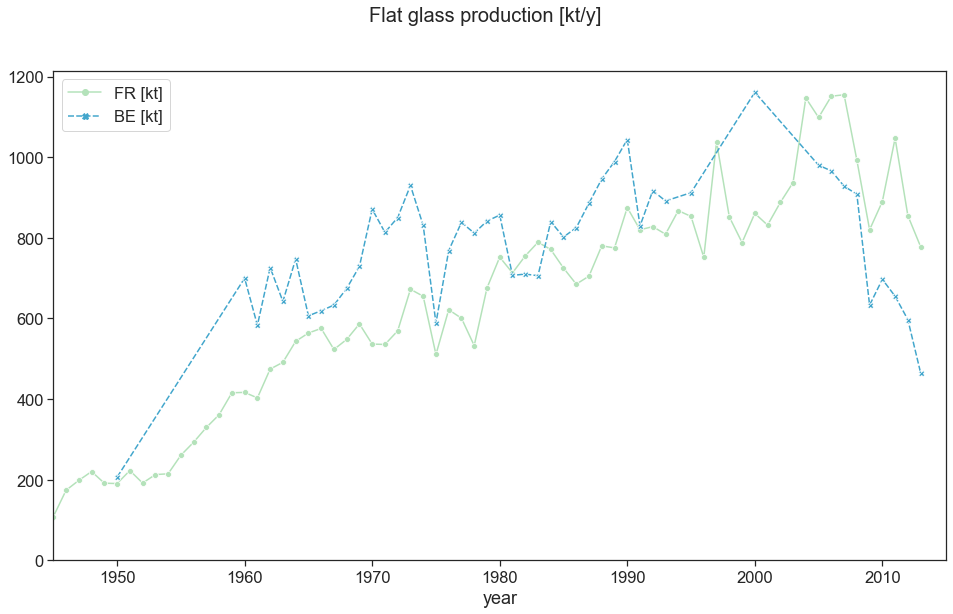

In [10]:
#Plotting FR and BE flat glass production
fig, ax = plt.subplots()

sns.lineplot(data=BE_FR_FlatGlassProd, markers=True, palette="GnBu")

ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)

fig.suptitle('Flat glass production [kt/y]', fontsize = 20)

Text(0.5, 0.98, 'Flat glass production (rolled) [kt/y]')

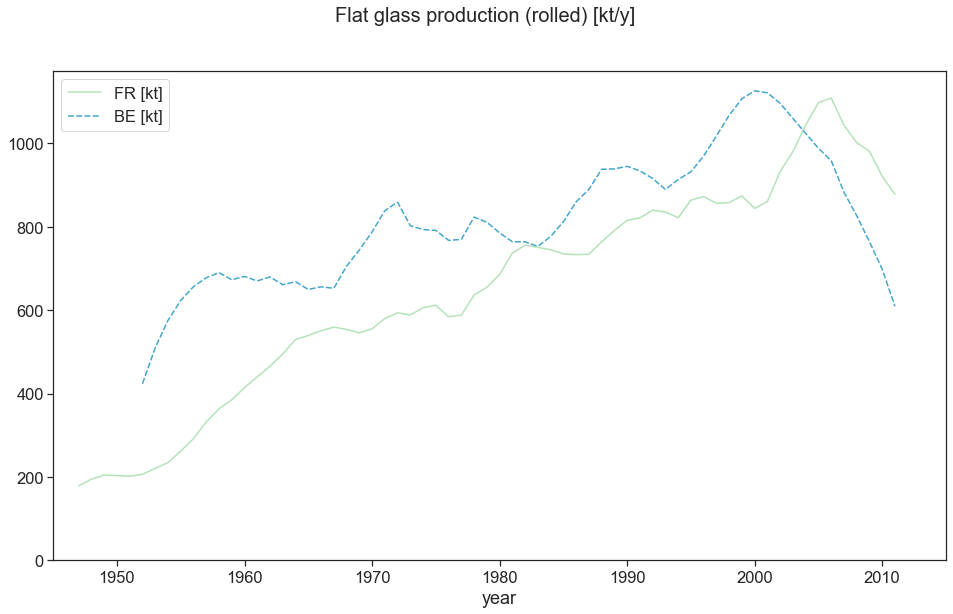

In [48]:
#Linear interpolation for flat glass production in order to "roll"
BE_FR_FlatGlassProd_roll \
    = BE_FR_FlatGlassProd.interpolate(method='pchip',
                                      limit_area='inside')

#Rolling flat glass production according to a 5-year mean
win_len = 5
BE_FR_FlatGlassProd_roll \
    = BE_FR_FlatGlassProd_roll.rolling(win_len,
                                       center=True).mean()

#Plotting rolled FR and BE flat glass production
fig, ax = plt.subplots()

sns.lineplot(data=BE_FR_FlatGlassProd_roll, palette="GnBu")

ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)

fig.suptitle('Flat glass production (rolled) [kt/y]', fontsize = 20)

## b. Consumption of flat glass

In [12]:
#Creating a DataFrame with import and export data
FR_Imp = FR_data.parse('import').set_index('year')
FR_Exp = FR_data.parse('export').set_index('year')

BE_Imp = BE_data.parse('import').set_index('year')
BE_Exp = BE_data.parse('export').set_index('year')

In [13]:
#Creating a new DataFrame for Belgian and French flat glass import/export
BE_FR_Imp = FR_Imp[['flat glass, kt']].copy()
BE_FR_Imp.rename(columns={'flat glass, kt':'FR [kt]'},
                 inplace=True)
BE_FR_Imp['BE [kt]'] = BE_Imp['flat glass, kt']

BE_FR_Exp = FR_Exp[['flat glass, kt']].copy()
BE_FR_Exp.rename(columns = {'flat glass, kt':'FR [kt]'},
                inplace = True)
BE_FR_Exp['BE [kt]'] = BE_Exp['flat glass, kt']

In [14]:
BE_FR_Imp[5:10]

,FR [kt],BE [kt]
year,,
1950,NaN,NaN
1951,NaN,NaN
1952,1.148,NaN
1953,1.133,NaN
1954,10.706,NaN


In [15]:
BE_FR_Exp[5:10]

,FR [kt],BE [kt]
year,,
1950,55.600,NaN
1951,NaN,NaN
1952,51.661,NaN
1953,55.203,215.532
1954,51.929,240.300


In [16]:
#Estimating the ratio importation/production and exportation/production
BE_FR_UseRatio = BE_FR_Exp.reset_index()[['year']].set_index('year')

BE_FR_UseRatio['FR, import ratio'] \
    = BE_FR_Imp['FR [kt]'] / BE_FR_FlatGlassProd['FR [kt]']
BE_FR_UseRatio['FR, export ratio'] \
    = BE_FR_Exp['FR [kt]'] / BE_FR_FlatGlassProd['FR [kt]']

BE_FR_UseRatio['BE, import ratio'] \
    = BE_FR_Imp['BE [kt]'] / BE_FR_FlatGlassProd['BE [kt]']
BE_FR_UseRatio['BE, export ratio'] \
    = BE_FR_Exp['BE [kt]'] / BE_FR_FlatGlassProd['BE [kt]']

BE_FR_UseRatio[-20:]

#Akima interpolation for missing data
BE_FR_UseRatio = BE_FR_UseRatio.interpolate(method='akima')

#Linear interpolation for the first years
BE_FR_UseRatio = BE_FR_UseRatio.interpolate(limit_direction='backward')

BE_FR_UseRatio[20:30]

,"FR, import ratio","FR, export ratio","BE, import ratio","BE, export ratio"
year,,,,
1965,0.046560,0.242671,0.039910,0.690864
1966,0.059631,0.238352,0.043811,0.691901
1967,0.083071,0.262896,0.043750,0.681756
1968,0.110057,0.290199,0.041997,0.667563
1969,0.132918,0.304572,0.040817,0.656456
1970,0.155431,0.314848,0.042480,0.655568
1971,0.177589,0.321446,0.049230,0.664767
1972,0.199389,0.324784,0.061129,0.678880
1973,0.220826,0.325281,0.077164,0.697486


(0.0, 3.098060051714452)

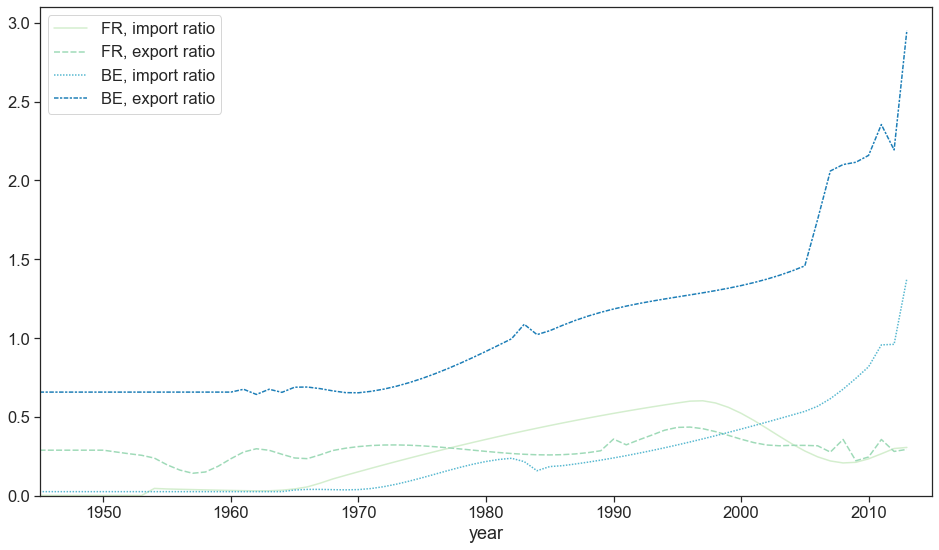

In [17]:
fig, ax = plt.subplots()

sns.lineplot(data=BE_FR_UseRatio, palette="GnBu")

ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)

In [18]:
BE_FR_Use = BE_FR_Exp.reset_index()[['year']].set_index('year')

BE_FR_Use['BE, flat glass consumption, [kt]'] \
    = BE_FR_FlatGlassProd['BE [kt]'] \
    + BE_FR_UseRatio['BE, import ratio'] \
    - BE_FR_UseRatio['BE, export ratio']

BE_FR_Use['FR, flat glass consumption, [kt]'] \
    = BE_FR_FlatGlassProd['FR [kt]'] \
    + BE_FR_UseRatio['FR, import ratio'] \
    - BE_FR_UseRatio['FR, export ratio']


BE_FR_Use[20:30]

,"BE, flat glass consumption, [kt]","FR, flat glass consumption, [kt]"
year,,
1965,605.859046,563.603888
1966,618.421910,575.021280
1967,632.464995,522.820174
1968,673.675434,547.719858
1969,728.406361,586.228346
1970,870.386912,536.240582
1971,812.879464,535.256143
1972,849.573248,569.074605
1973,929.260678,672.195545


(0.0, 1207.1296822594702)

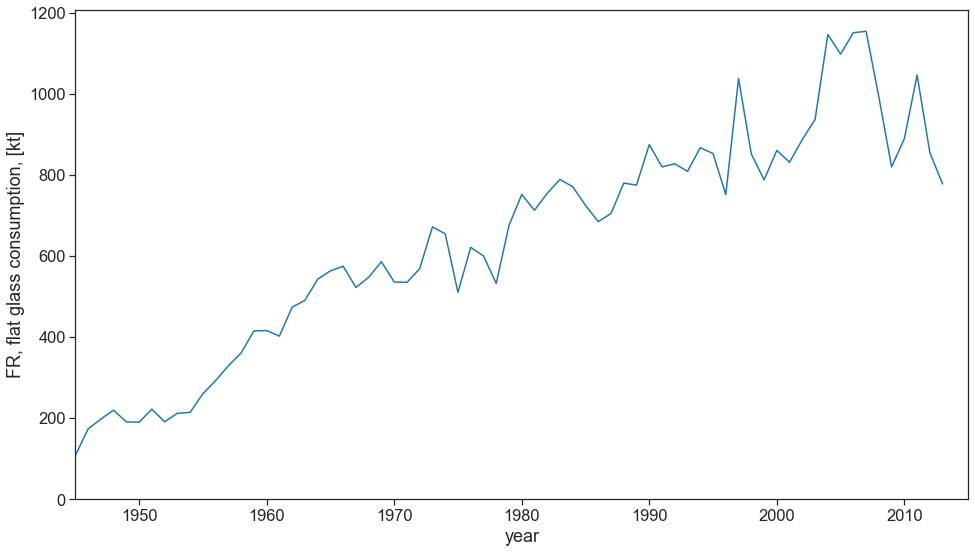

In [19]:
ToPlot = BE_FR_Use.reset_index()

fig, ax = plt.subplots()

sns.lineplot(data=ToPlot, x='year', 
             y='FR, flat glass consumption, [kt]',
             palette="Reds")

ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)

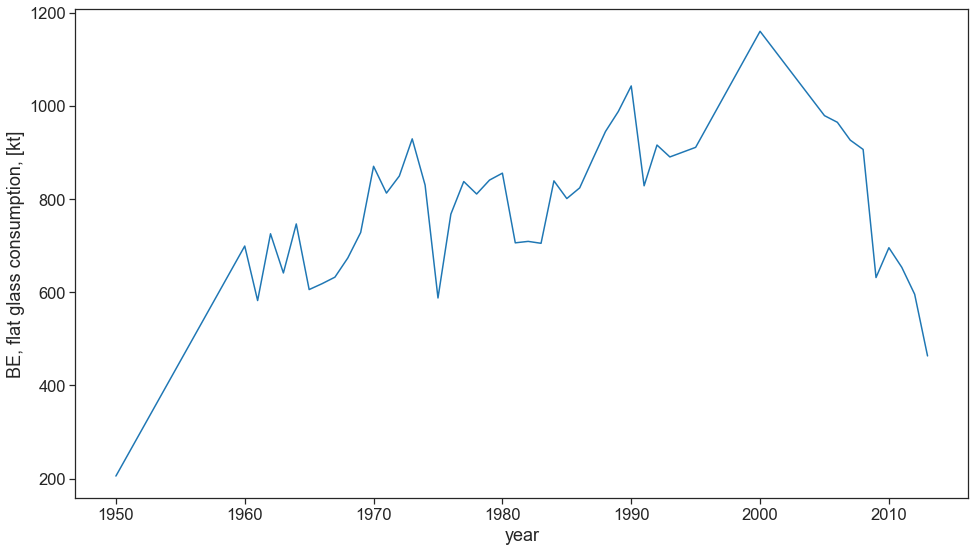

In [20]:
sns.lineplot(data=ToPlot, x='year', 
             y='BE, flat glass consumption, [kt]',
             palette="Blues")

## c. Production of architectural flat glass

In [21]:
#Share of building glass in the French production of flat glass
BldgShare = FR_Prod[['bldg glass/flat glass, %']]

ShareFR = BldgShare[['bldg glass/flat glass, %']].dropna()
print(ShareFR.isnull().sum())
ShareFR

bldg glass/flat glass, %    0
dtype: int64


,"bldg glass/flat glass, %"
year,
1947,0.90
1952,0.80
1962,0.68
1968,0.50
1980,0.50
1994,0.50
2002,0.52
2004,0.49


In [22]:
#Estimating parameters a and b of the regression lines

ShareFR['Trend1'] = ShareFR['bldg glass/flat glass, %'][:4]
ShareFR['Trend2'] = ShareFR['bldg glass/flat glass, %'][-5:]

ShareFR = ShareFR.reset_index()

x1 = list(ShareFR['year'][:4])
y1 = list(ShareFR['Trend1'][:4])
a1, b1 = np.polyfit(x1, y1, 1)

x2 = list(ShareFR['year'][-5:])
y2 = list(ShareFR['Trend2'][-5:])
a2, b2 = np.polyfit(x2, y2, 1)

#Point of intersection of the two regression lines
xi = (b1-b2) / (a2-a1)
print('Approximate year of rate change:', round(xi,0))

Approximate year of rate change: 1970.0


Text(0.5, 0.98, 'Share of building glass in the French flat glass production, %')

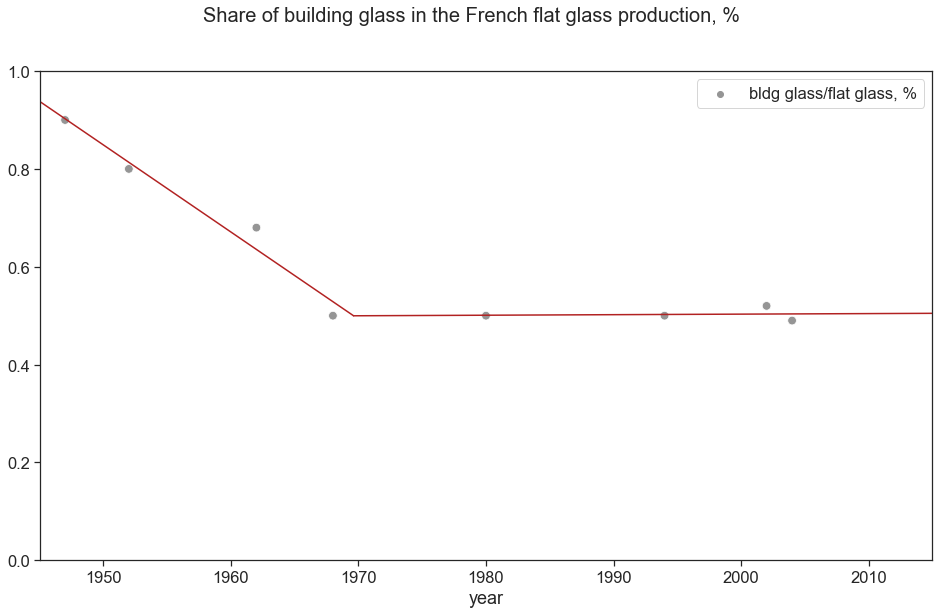

In [23]:
fig, ax = plt.subplots()

sns.scatterplot(data = BldgShare, s=75, palette='Greys')

A = np.linspace(1945,xi)
ax.plot(A, a1 * A + b1, color='firebrick')
B = np.linspace(xi,2020)
ax.plot(B, a2 * B + b2, color='firebrick')

ax.set_ylim(0,1)
ax.set_xlim(1945,2015)
fig.suptitle('Share of building glass in the French flat glass production, %', 
             fontsize = 20)

In [24]:
#Update dataset according to regression lines
BldgShare = BldgShare.reset_index()

BldgShare.loc[(BldgShare['year'] < xi), 'bldg glass/flat glass, %'] \
    = round(a1 * BldgShare['year'] + b1, 2)

BldgShare.loc[(BldgShare['year'] >= xi), 'bldg glass/flat glass, %'] \
    = round(a2 * BldgShare['year'] + b2, 2)

BldgShare = BldgShare.set_index('year')
BldgShare

,"bldg glass/flat glass, %"
year,
1945,0.94
1946,0.92
1947,0.90
1948,0.88
1949,0.87
...,...
2016,0.50
2017,0.51
2018,0.51


In [25]:
#Estimate architectural flat glass production in France and Belgium
BE_FR_BldgGlassProd = BldgShare.reset_index()[['year']].set_index('year')

BE_FR_BldgGlassProd['FR [kt]'] \
    = (BE_FR_FlatGlassProd['FR [kt]']
       * BldgShare['bldg glass/flat glass, %'])

BE_FR_BldgGlassProd['BE [kt]'] \
    = (BE_FR_FlatGlassProd['BE [kt]']
       * BldgShare['bldg glass/flat glass, %'])

BE_FR_BldgGlassProd.head()

,FR [kt],BE [kt]
year,,
1945,101.802,NaN
1946,159.896,NaN
1947,178.470,NaN
1948,193.776,NaN
1949,166.431,NaN


Text(0.5, 0.98, 'Architectural flat glass production [kt/y]')

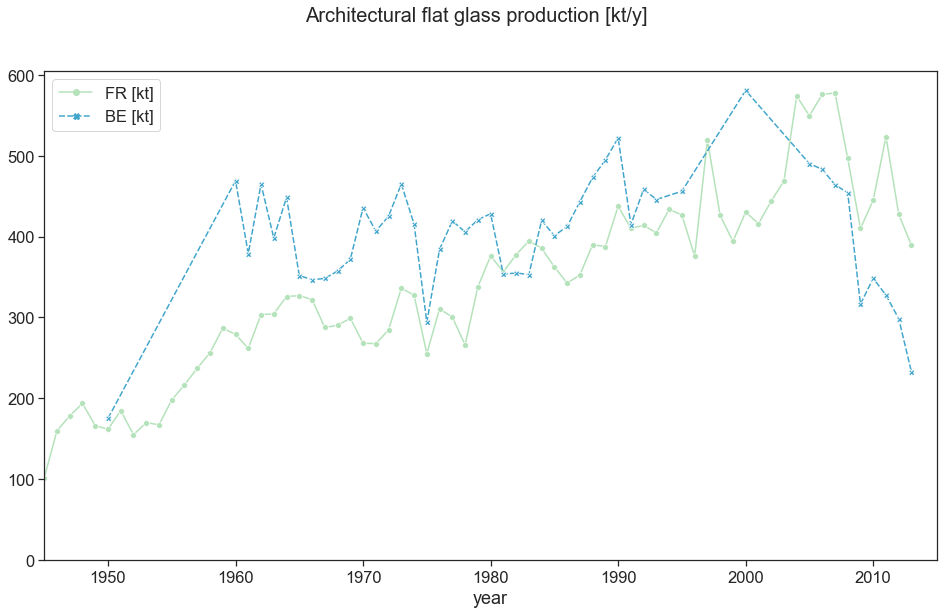

In [26]:
#Plotting FR and BE bldg flat glass production
fig, ax = plt.subplots()

sns.lineplot(data=BE_FR_BldgGlassProd, markers=True, palette="GnBu")

ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)

fig.suptitle('Architectural flat glass production [kt/y]', fontsize = 20)

Text(0.5, 0.98, 'Architectural flat glass production (rolled) [kt/y]')

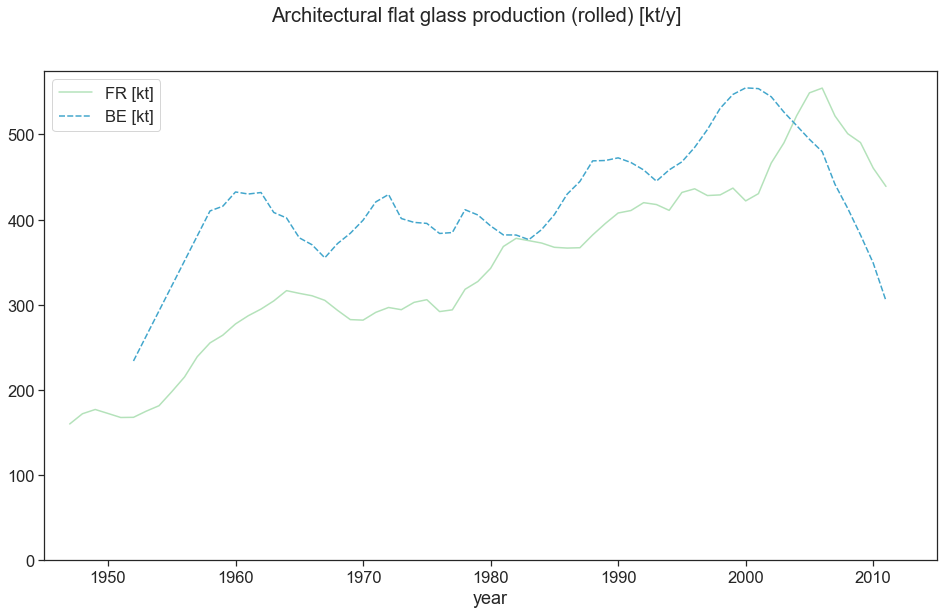

In [49]:
#Linear interpolation for bldg glass production in order to "roll"
BE_FR_BldgGlassProd_roll \
    = BE_FR_BldgGlassProd.interpolate(method = 'linear',
                                      limit_area = 'inside')

#Rolling flat glass production according to a 5-year mean
win_len = 5
BE_FR_BldgGlassProd_roll \
    = BE_FR_BldgGlassProd_roll.rolling(win_len,
                                       center = True).mean()

#Plotting results, to be compared with above graph
fig, ax = plt.subplots()

sns.lineplot(data=BE_FR_BldgGlassProd_roll, palette="GnBu")

ax.set_xlim(1945,2015)
ax.set_ylim(ymin=0)

fig.suptitle('Architectural flat glass production (rolled) [kt/y]', 
             fontsize = 20)

## d. Production of insulating glass units in France

In [28]:
#Creating a new DataFrame for French IGU
FR_IGU = FR_Prod[['IGU, "000 m²']]
FR_IGU = FR_IGU.rename(columns={'IGU, "000 m²':'prod ["000 m²]'})

FR_IGU['import ["000 m²]'] = FR_Imp['IGU, "000 m²']
FR_IGU['export ["000 m²]'] = FR_Exp['IGU, "000 m²']

FR_IGU['consumption ["000 m²]'] \
    = FR_IGU['prod ["000 m²]'] + FR_IGU['import ["000 m²]'] \
    - FR_IGU['export ["000 m²]']

FR_IGU[-10:]

,"prod [""000 m²]","import [""000 m²]","export [""000 m²]","consumption [""000 m²]"
year,,,,
2011,16997.708,952.462,405.729,17544.441
2012,16424.399,628.725,429.054,16624.070
2013,15763.493,627.096,462.902,15927.687
2014,15000.332,555.118,498.605,15056.845
2015,15062.705,387.240,476.730,14973.215
2016,15192.061,346.616,507.427,15031.250
2017,15696.879,321.060,630.420,15387.519
2018,16462.590,437.020,651.881,16247.729
2019,17206.730,413.427,820.091,16800.066


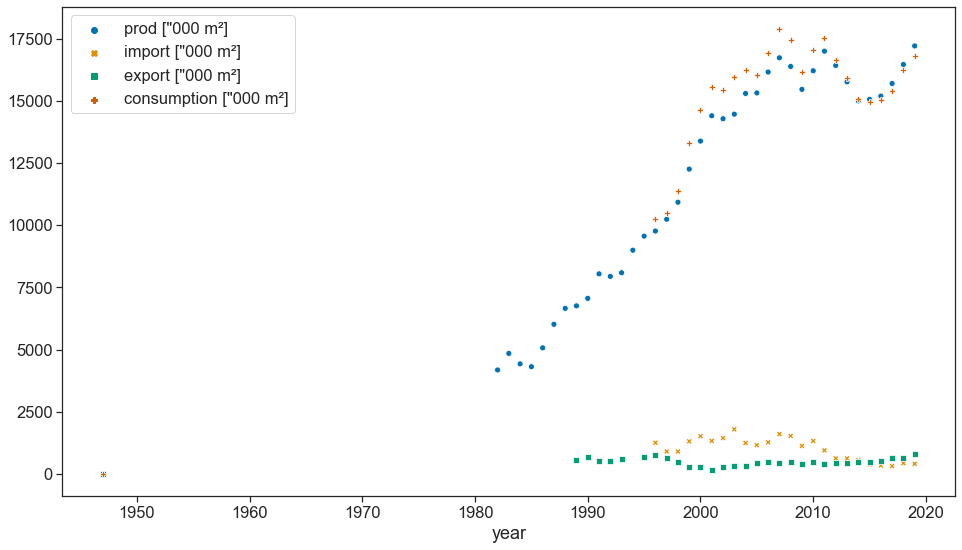

In [29]:
sns.scatterplot(data=FR_IGU, palette='colorblind')

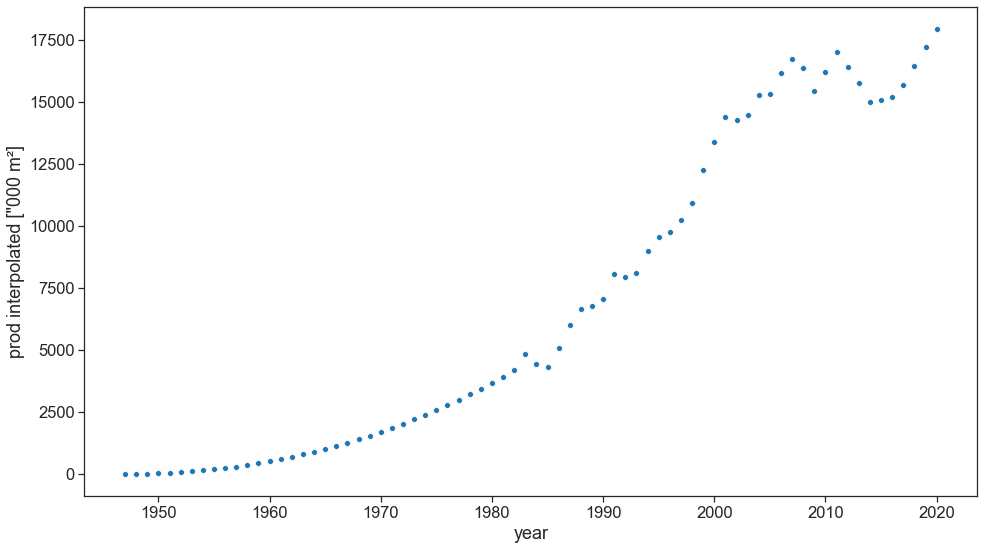

In [30]:
FR_IGU['prod interpolated ["000 m²]'] = FR_IGU['prod ["000 m²]'].interpolate(method = 'pchip')

toplot = FR_IGU.reset_index()
sns.scatterplot(data=toplot, x='year', y='prod interpolated ["000 m²]')

In [31]:
#Estimating consumption/production ratio over the period 1995-2000
FR_IGU['consumption/production [-]'] \
    = FR_IGU['consumption ["000 m²]'] / FR_IGU['prod ["000 m²]']

a = FR_IGU.loc[1995:2000, 'consumption/production [-]'].mean().round(2)
print("Mean consumption/production ratio, 1995-2000:", a)

FR_IGU['consumption/production [-]'][1945] = 0
FR_IGU.head()

Mean consumption/production ratio, 1995-2000: 1.06


,"prod [""000 m²]","import [""000 m²]","export [""000 m²]","consumption [""000 m²]","prod interpolated [""000 m²]",consumption/production [-]
year,,,,,,
1945,NaN,NaN,NaN,NaN,NaN,0.0
1946,NaN,NaN,NaN,NaN,NaN,NaN
1947,0.0,0.0,0.0,0.0,0.000000,NaN
1948,NaN,NaN,NaN,NaN,2.847768,NaN
1949,NaN,NaN,NaN,NaN,11.457867,NaN


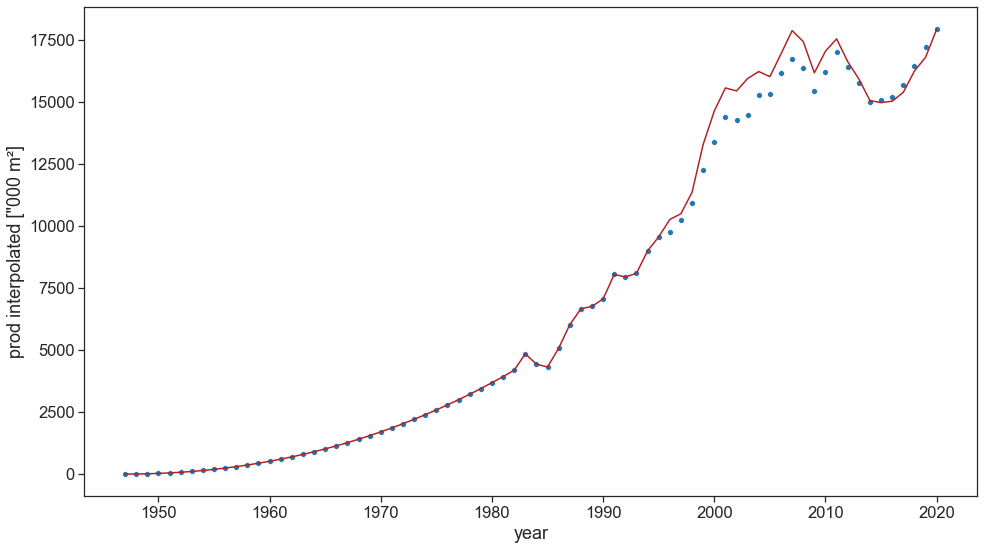

In [80]:
#Estimating consumption since 1945
filt_null = FR_IGU['consumption ["000 m²]'].isnull()

FR_IGU.loc[filt_null, 'consumption ["000 m²]'] \
    = FR_IGU.loc[filt_null, 'prod interpolated ["000 m²]']

FR_IGU = FR_IGU.reset_index()

fig, ax = plt.subplots()

sns.scatterplot(data=FR_IGU, x='year', 
                y='prod interpolated ["000 m²]', palette='Reds')

ax.plot(FR_IGU['year'], FR_IGU['consumption ["000 m²]'], color='firebrick')

FR_IGU = FR_IGU.set_index('year')

Text(0.5, 0.98, 'IGU (rolled) [kt/y]')

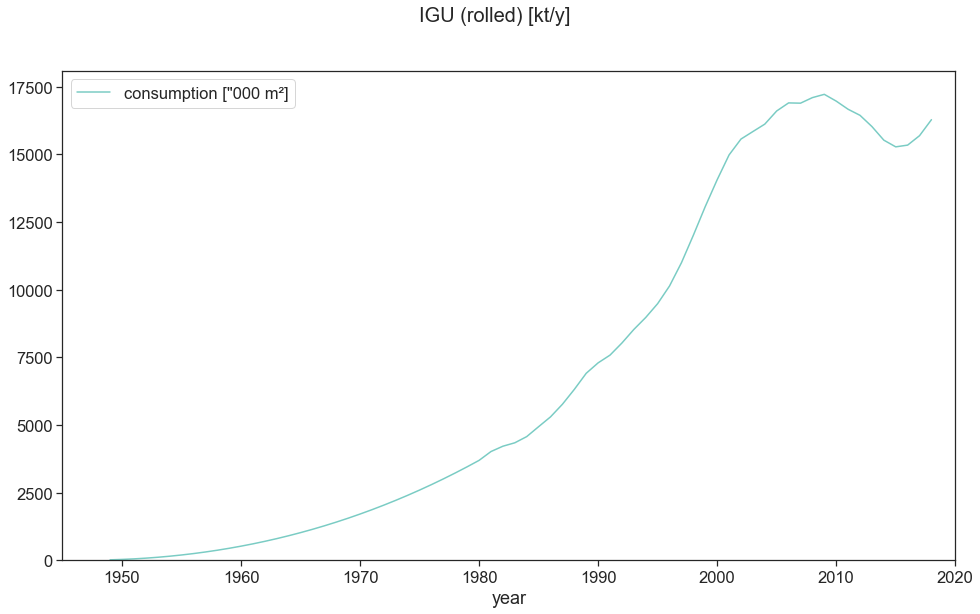

In [117]:
#Rolling IGU consumption data according to a 5-year mean
FR_IGU_roll = FR_IGU[['consumption ["000 m²]']].copy()

win_len = 5
FR_IGU_roll = FR_IGU_roll.rolling(win_len, center = True).mean()

#Plotting results, to be compared with above graph
fig, ax = plt.subplots()

sns.lineplot(data = FR_IGU_roll, palette="GnBu")

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)

fig.suptitle('IGU (rolled) [kt/y]', 
             fontsize = 20)

# 2. CO2 emissions of the French and Belgian flat glass industry since 1945

# a. Evolution of the carbon intensity

In [33]:
#Creating a DataFrame only with CO2 emission data
Emissions = FR_data.parse('emissions').set_index('year')

CO2_Intensity = Emissions[['CO2 glass ind, kg/t']].copy()
CO2_Intensity.rename(columns={'CO2 glass ind, kg/t':'CO2 [kg/t]'}, 
           inplace=True)

CO2_Intensity.dropna()

,CO2 [kg/t]
year,
1947,2100.0
1950,2050.0
1960,1725.0
1965,1525.0
1970,1340.0
1975,1075.0
1980,900.0
1985,800.0
1990,690.0


(0.0, 2179.5)

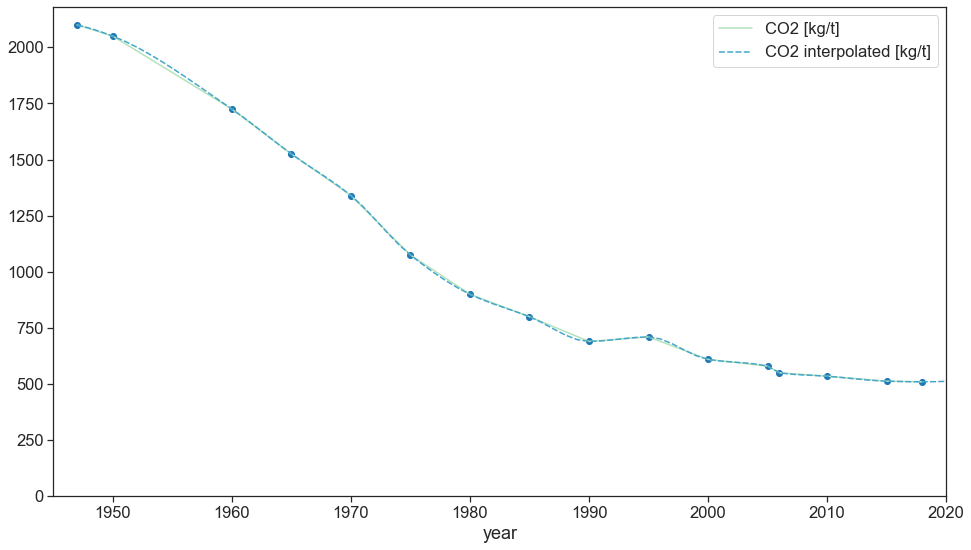

In [34]:
CO2_Intensity['CO2 interpolated [kg/t]'] \
    = CO2_Intensity['CO2 [kg/t]'].interpolate('pchip')

fig, ax = plt.subplots()
sns.lineplot(data=CO2_Intensity, palette="GnBu")

ax.scatter(x = CO2_Intensity.index, y = CO2_Intensity['CO2 [kg/t]'])

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)

## b. Absolute CO2 emissions since 1945

In [35]:
CO2_ABS = CO2_Intensity.reset_index()[['year']].set_index('year')

CO2_ABS['FR flat glass [kt]'] \
    = BE_FR_FlatGlassProd['FR [kt]'] \
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
CO2_ABS['BE flat glass [kt]'] \
    = BE_FR_FlatGlassProd['BE [kt]'] \
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000

CO2_ABS['FR bldg glass [kt]'] \
    = BE_FR_BldgGlassProd['FR [kt]'] \
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
CO2_ABS['BE bldg glass [kt]'] \
    = BE_FR_BldgGlassProd['BE [kt]'] \
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000

CO2_ABS

,FR flat glass [kt],BE flat glass [kt],FR bldg glass [kt],BE bldg glass [kt]
year,,,,
1945,NaN,NaN,NaN,NaN
1946,NaN,NaN,NaN,NaN
1947,416.430000,NaN,374.787000,NaN
1948,459.311311,NaN,404.193954,NaN
1949,395.862631,NaN,344.400489,NaN
...,...,...,...,...
2016,NaN,NaN,NaN,NaN
2017,NaN,NaN,NaN,NaN
2018,NaN,NaN,NaN,NaN


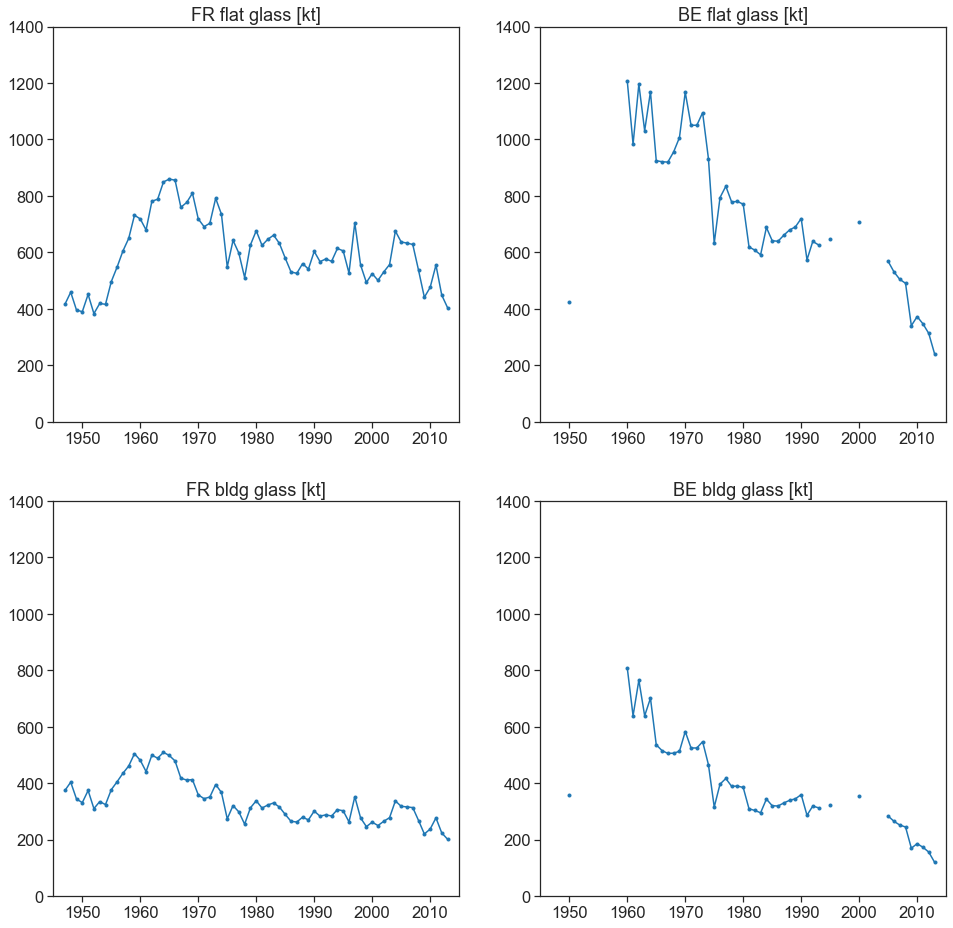

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

for i, (ax, col) in enumerate(zip(axes.flatten(), CO2_ABS.columns)):

    ax.plot(CO2_ABS.index, CO2_ABS[col], marker=".")
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(0,1400)

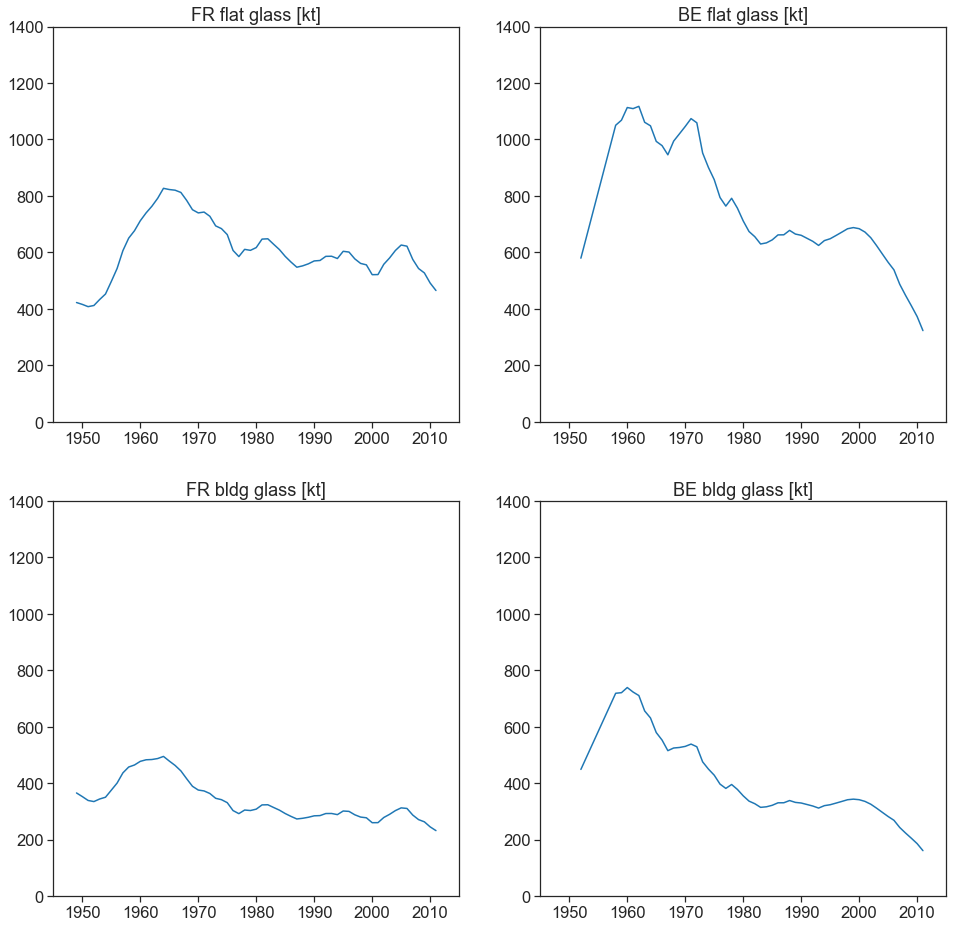

In [53]:
#Linear interpolation for CO2 absolute emissions in order to "roll"
CO2_ABS_roll = CO2_ABS
CO2_ABS_roll = CO2_ABS_roll.interpolate(method='linear', 
                                        limit_area = 'inside')

#Rolling CO2 emissions according to a 5-year mean
win_len = 5
CO2_ABS_roll = CO2_ABS_roll.rolling(win_len,
                                    center = True).mean()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

for i, (ax, col) in enumerate(zip(axes.flatten(), CO2_ABS_roll.columns)):

    ax.plot(CO2_ABS_roll.index, CO2_ABS_roll[col])
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(0,1400)

(0.0, 243.69909568261377)

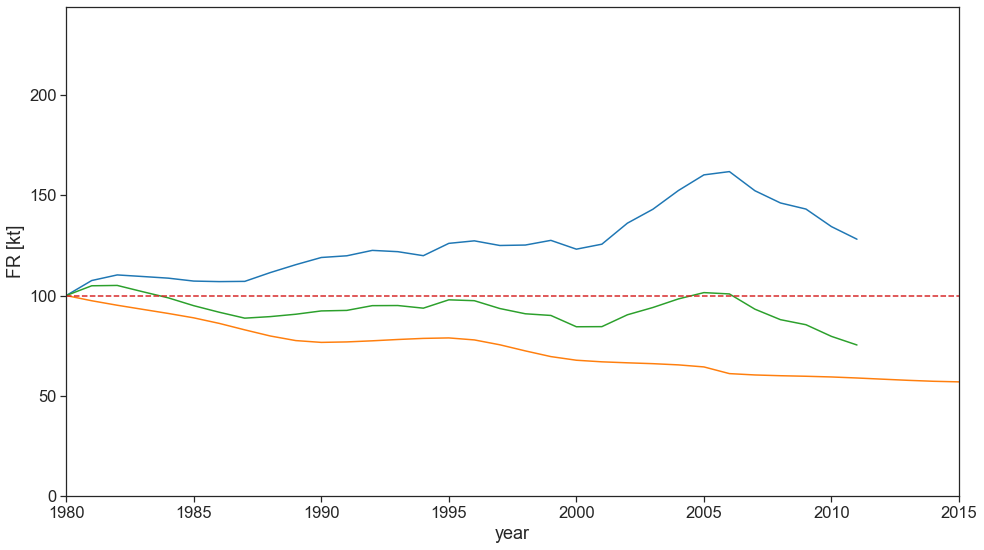

In [66]:
#Base 100 = 1990
FlatGlassProd_diff \
    = 100 * BE_FR_FlatGlassProd_roll / BE_FR_FlatGlassProd_roll.loc[1980]

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_diff = 100 * CO2_ABS_roll / CO2_ABS_roll.loc[1980]

#Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots()
sns.lineplot(data = FlatGlassProd_diff, 
             x = FlatGlassProd_diff.index, 
             y = 'FR [kt]',
             palette = "GnBu")

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_diff.index, 
        CO2ABS_diff['FR flat glass [kt]'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)

(0.0, 244.27992021276597)

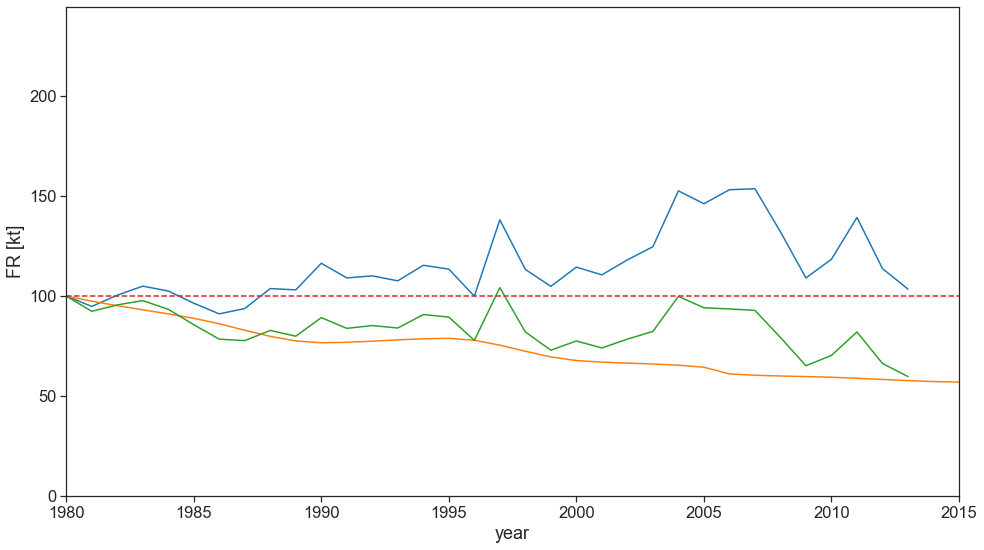

In [67]:
#Base 100 = 1990
FlatGlassProd_diff_noroll \
    = 100 * BE_FR_FlatGlassProd / BE_FR_FlatGlassProd.loc[1980]

CO2Intensity_diff_noroll = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_diff_noroll = 100 * CO2_ABS / CO2_ABS.loc[1980]

#Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots()
sns.lineplot(data = FlatGlassProd_diff_noroll, 
             x = FlatGlassProd_diff_noroll.index, 
             y = 'FR [kt]',
             palette = "GnBu")

ax.plot(CO2Intensity_diff_noroll.index, 
        CO2Intensity_diff_noroll['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_diff_noroll.index, 
        CO2ABS_diff_noroll['FR flat glass [kt]'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)

## c. CO2 emissions relating to IGU consumption in FR

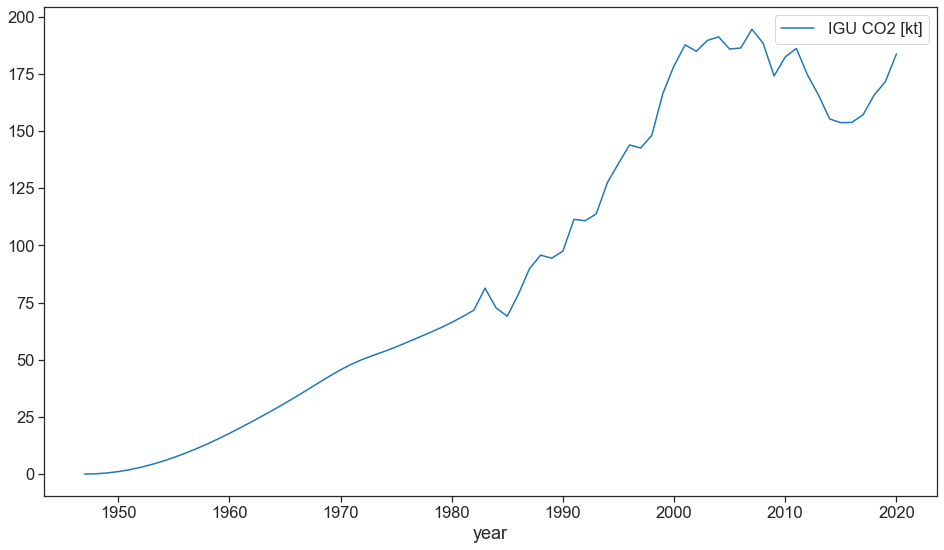

In [118]:
#Hypothesis: The average thickness of an IGU is twice 4mm, 
#i.e., 8mm of glass, which equals 20kg per m²
FR_IGU['consumption [kt]'] = FR_IGU['consumption ["000 m²]'] * 20 / 1000

#Absolute CO2 emissions in France
CO2_IGU = FR_IGU['consumption [kt]'] \
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000

CO2_IGU = pd.DataFrame(CO2_IGU, columns = ['IGU CO2 [kt]'])

#Plotting
sns.lineplot(data = CO2_IGU)

(0.0, 198.92385648185726)

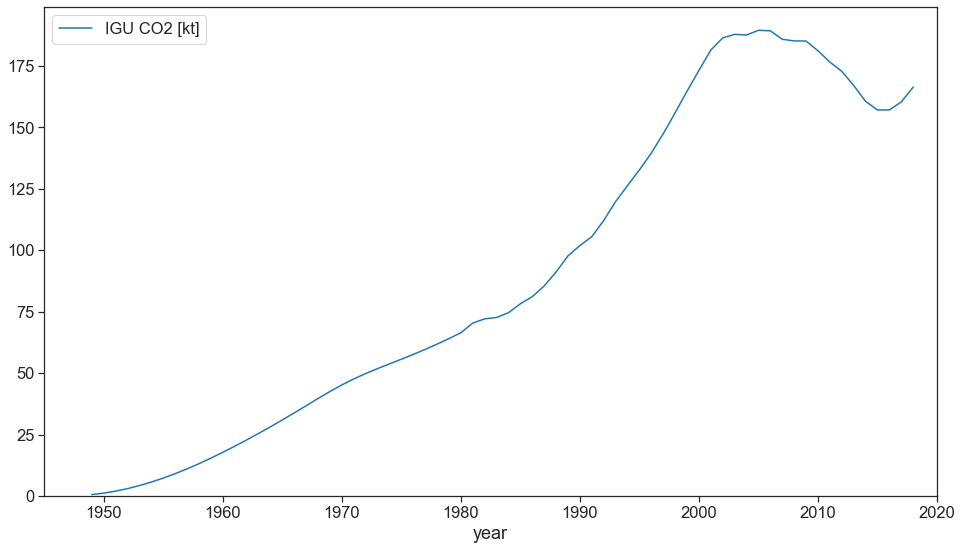

In [119]:
#Rolling CO2 emissions of IGU according to a 5-year mean
win_len = 5
CO2_IGU_roll = CO2_IGU.rolling(win_len, center = True).mean()

#Plotting
fig, ax = plt.subplots()

sns.lineplot(data = CO2_IGU_roll)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)

(0.0, 489.5712065741075)

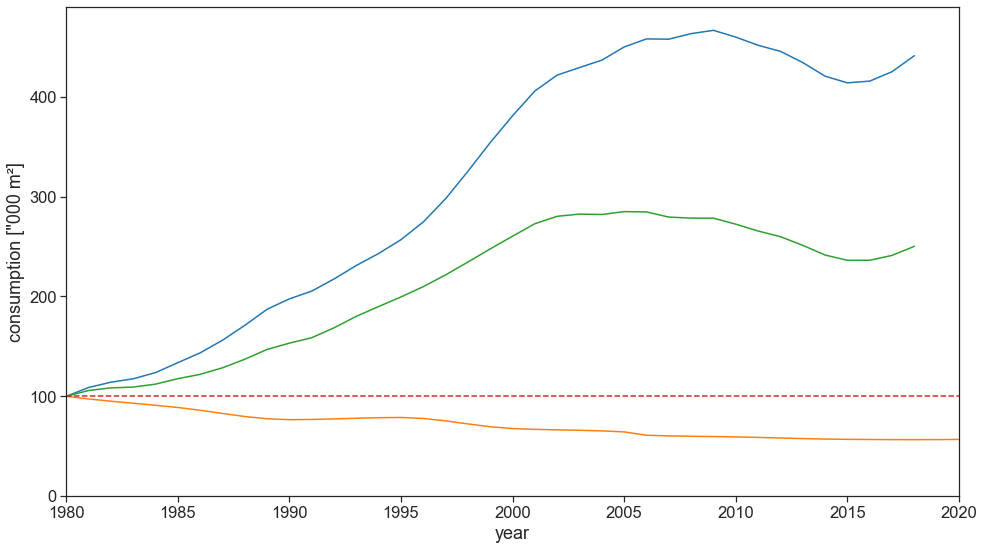

In [121]:
#Base 100 = 1990
CO2_IGU_diff_roll = 100 * CO2_IGU_roll / CO2_IGU_roll.loc[1980]
FR_IGU_diff_roll = 100 * FR_IGU_roll / FR_IGU_roll.loc[1980]

#Plotting consumption, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots()

sns.lineplot(data = FR_IGU_diff_roll, 
             x = FR_IGU_diff_roll.index, 
             y = 'consumption ["000 m²]',
             palette = "GnBu")

ax.plot(CO2Intensity_diff_noroll.index, 
        CO2Intensity_diff_noroll['CO2 interpolated [kg/t]'])
ax.plot(CO2_IGU_diff_roll.index, 
        CO2_IGU_diff_roll['IGU CO2 [kt]'])

ax.plot([1980, 2020], [100, 100], '--')

ax.set_xlim(1980,2020)
ax.set_ylim(ymin=0)

# 3. Postprocessing of the European dataset

## a. Production of flat glass

In [122]:
EU_Prod = EU_data.parse('prod').set_index(['Nbr of countries', 'year'])
EU_Prod

flat glass, kt  bldg glass/flat glass, %  IGU, "000 m²  \
Nbr of countries year                                                           
6                1945             NaN                       NaN           NaN   
                 1946             NaN                       NaN           NaN   
                 1947             NaN                       NaN           NaN   
                 1948             NaN                       NaN           NaN   
                 1949             NaN                       NaN           NaN   
...                               ...                       ...           ...   
28               2015          9641.0                       NaN    116000.000   
                 2016          9835.0                       NaN    114000.000   
                 2017         10665.0                       NaN    121600.000   
                 2018         10643.0                       0.8    117011.436   
                 2019         10840.0                       NaN    121061.246   

                       float glass w/ reflecting layer, "000 m²  \
Nbr of countries year                                             
6                1945                                       NaN   
                 1946                                       NaN   
                 1947                                       NaN   
                 1948                                       NaN   
                 1949                                       NaN   
...                                                         ...   
28               2015                                290030.243   
                 2016                                302527.228   
                 2017                                286038.313   
                 2018                                287262.007   
                 2019                                296506.851   

                       LSG for bldg, "000 m²  TSG for bldg, "000 m²  
Nbr of countries year                                                
6                1945                    NaN                    NaN  
                 1946                    NaN                    NaN  
                 1947                    NaN                    NaN  
                 1948                    NaN                    NaN  
                 1949                    NaN                    NaN  
...                                      ...                    ...  
28               2015              94520.954              57000.000  
                 2016              85681.248              55864.316  
                 2017              86735.168              57552.178  
                 2018              84718.143              50337.613  
                 2019              95316.274              51128.069  

[90 rows x 6 columns]

Text(0.5, 0.98, 'European production of flat glass [kt/y]')

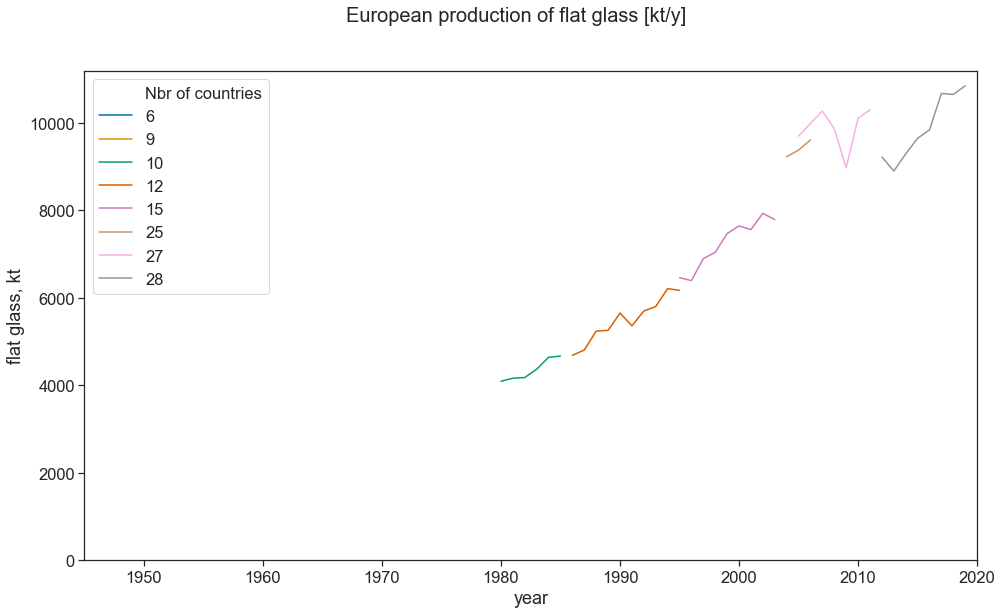

In [123]:
#Plot the European production of flat glass

EUplot = EU_Prod.reset_index()

fig, ax = plt.subplots()

sns.lineplot(data = EUplot, x = 'year', y = 'flat glass, kt', 
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('European production of flat glass [kt/y]', fontsize = 20)

## b. Production of architectural flat glass

In [41]:
#Share of building glazing in the European production of flat glass
RatioEU = EU_Prod[['bldg glass/flat glass, %']].dropna()
RatioEU

,,"bldg glass/flat glass, %"
Nbr of countries,year,
9,1978,0.572
15,1996,0.520
28,2018,0.800
